# Fractals

Generation of Mandelbrots, Multibrots, and other fractals with Python

In [374]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import math
import random
import typing

In [207]:
abs(complex(-5, -10))

11.180339887498949

In [344]:
def t():
    t.a = 5
t.a

AttributeError: 'function' object has no attribute 'a'

In [357]:
Fractal.norm.params

7

In [379]:
test = list[int, Fractal]
(list, (int,))
test
# __annotations__
str(test)
vars(test)
typing.get_origin(test)
typing.get_args(test)

(int, __main__.Fractal)

In [466]:
f8 = Fractal()
f8.scale(-3, 0, 0.01)
np.interp(-0.5, [-1, 1], [0, 30])
np.interp([-2.9, 1.4], [-2, 2], [0, 50])

array([ 0. , 42.5])

In [480]:
(0, 0) in [int]

False

In [621]:
def tile(ims, n, d):
    ims = np.reshape(ims, [*n, *d])
    combined = np.concatenate(np.concatenate(ims, axis=2), axis=0)
    return combined

log = math.log
class Fractal:
    info = 'A generic fractal wrapper; describes a mathematical object with self-similar properties'
    
    def __init__(
            self,
            z=0,
            d=2,
            b=10e5,
            n=20,
            o=(0., 0.),
            m=4,
            r=(100, 200),
            frame=None,
            radius=2,
            point_spacing=0.1
        ):
        if type(r) is int:
            r = [r] * 2
        if type(o) in [int, float]:
            o = [o] * 2
        
        self.r = np.array(r)
        self.o = np.array(o)
        self.z = z
        self.d = d
        self.b = b
        self.m = m
        self.n = n
        
        self.radius = radius
        g = self.radius
        if not frame:
            frame = [[-g, g], [-g, g]]
        self.frame = np.array(frame)# + self.o
        self.f1, self.f2 = self.frame
#         m?

        self.point_spacing = point_spacing
        self.image_size = np.array(np.array([g*2, g*2]) / self.point_spacing, dtype=int)
        print(self.f1)
#         self.image_size = list(map(round, self.image_size))
        self.width, self.height = self.image_size
        
#         self.generate()
        
    def generate(self):
        imsize = self.image_size
        self.canvas = np.zeros(imsize)
        self.iterations = np.zeros(imsize)
#         for x, y in np.ndindex(self.canvas.shape):
        x1, x2, y1, y2 = *self.f1, *self.f2
        ps = self.point_spacing
        points = np.mgrid[x1:x2:ps, y1:y2:ps].reshape(2,-1).T
        for coordinate in points:
            z_ = self.z
#             c = (complex(y, x) / self.r[0] + complex(*self.o)) * self.m
            x, y = coordinate
            c = complex(y, x)
            for i in range(self.n):
                z_ = z_ ** self.d + c
                if abs(z_) > self.b:
#                     index = list(map(round, coordinate * 10))
                    coord_mapping = np.interp(coordinate, [x1, x2], [0, self.width-1])
#                     index = list(map(round, coord_mapping))
                    index = tuple(map(math.floor, coord_mapping))
    #                 canvas[x, y] += i
                    self.canvas[index] = self.norm(abs(z_), i)
#                     self.canvas[index] = i
                    self.iterations[index] = i
                    break
        it = self.iterations
        ca = self.canvas
#         self.canvas = self.scale(self.canvas, it.min(), it.max())
        self.canvas = np.interp(self.canvas, [ca.min(), ca.max()], [it.min(), it.max()])
        self.canvas = self.canvas ** (1/2)
#         print(self.canvas)
        return self.canvas

    def norm(self, x, i):
        norm.params = 7
    #     print(x)
        if x == 0:
            y = 0
        else:
            y = i + 1 - log(abs(log(x))) / log(2)
        return y
#     self.norm.params = 7
#     setattr(self.norm, 'params', 7)
#     norm.params = 7

    def scale(self, x, a, b):
        #return (x - a) / (b - a)
        pass
    scale.info = 'Map a value to a new range based on a minimum and maximum'
    scale.params = [
        ('x', [int, float, np.ndarray], 'The value to map'),
        ('a', [int, float], 'The minimum value of the target range'),
        ('b', [int, float], 'The maximum value of the target range')
    ]
    scale.returns = ('original')
    
    def render(self):
        points = self.generate()
        image = points
        return image
    
    def display(self, cmap=plt.colormaps()):
        if type(cmap) in [list, tuple]:
            cmap = random.choice(cmap)
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot()
        image = self.render()
        ax.imshow(image, cmap=cmap)
        plt.axis('off')
        return fig, ax
    
    def find_regions(self, func=np.var, num=5):
        self.generate()
        blocks = []
        w, h = np.array(self.r / num, dtype=int)
        for a in range(num):
            for b in range(num):
                block = self.canvas[a*h: (a+1)*h, b*w: (b+1)*w]
                variance = func(block)
                blocks.append([a, b, w, h, variance])
        return blocks
    
    def autozoom(self):
        region = self.find_regions()
        region.sort(key=lambda x: x[-1], reverse=True)
        region = region[0]
        a, b, w, h, v = region
        region = self.canvas[a*h: (a+1)*h, b*w: (b+1)*w]
        return region
    
    def __call__(self):
        return self.display()



[-2  2]


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

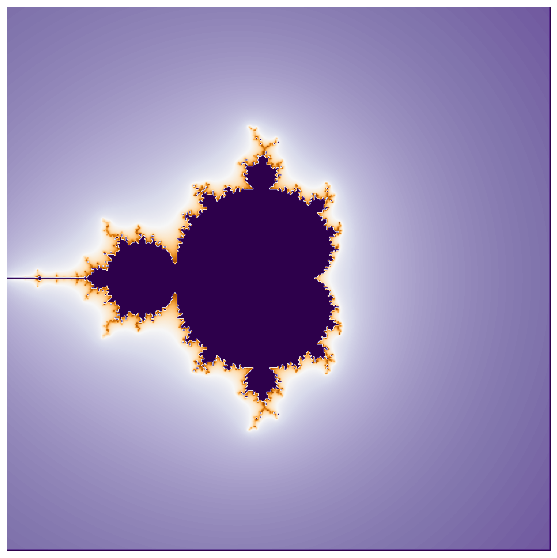

In [622]:
class FractalSet:
    def __init__(self, **kwargs):
        self.fractals = []
#         w = {a:b for (a, b) in kwargs.items() if type(b[0]) in [int, float]}
        w = {}
        self.fixed = {}
        for a, b in kwargs.items():
#             if type(b[0]) in [int, float]:
#             if len(b) == 3:
            if a not in 'r' and type(b) in [list, tuple]:
                if len(b) == 2:
                    b.append(kwargs['q'])
                w[a] = b
            elif a not in 'q':
                self.fixed[a] = b
        self.mdims = [b[-1] for a, b in w.items()]
        self.params = product(*[np.linspace(*b) for a, b in w.items()])
    
    def render(self, **kwargs):
        for p in self.params:
            self.fractals.append(generate(*p, **self.fixed))
        composite = self.fractals
        if 'axes' in kwargs and kwargs['axes']:
            print(kwargs['axes'][0])
            composite = kwargs['axes'][0](self.fractals, axis=0)
            self.mdims = [1, 1]
        composite = tile(composite, self.mdims, self.fixed['r'])
        return composite
    
    def __call__(self, **kwargs):
        return self.render(**kwargs)
    
# f = generate(r=(500, 1000), b=10, n=30, o=(-1, -0.5), m=2)
# f = Fractal(r=(50, 50), b=10, n=30, o=(-1, -0.5), m=2)
# f = FractalSet(z=[0, 1.5], d=[1, 5], r=[200]*2, q=10)(axes=[])
# print(f.find_regions())
# block = f.autozoom()
# f_ = f()
# ax.imshow(f, cmap='plasma')
# ax.imshow(block)
# plt.axis('off')
# list or dict for params?

f = Fractal(b=10, n=30, r=(80, 80), o=(-0.1, 0.01), m=2, radius=2, point_spacing=0.01)
f()

# TODO: multicolored fractals

In [601]:
np.var(np.random.uniform(0, 1, [5, 5, 3]))

0.09482205594645034

In [505]:
f.generate()

NameError: name 'x1' is not defined